# Complex NetCDF to Zarr Recipe: TerraClimate 

## About the Dataset

From http://www.climatologylab.org/terraclimate.html:

> TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019. We plan to update these data periodically (annually).

## What makes it tricky

This is an advanced example that illustrates the following concepts
- _Multiple variables in different files_: There is one file per year for a dozen different variables.
- _Complex Preprocessing_: We want to apply different preprocessing depending on the variable. This example shows how.


In [1]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
import xarray as xr

## Define Filename Pattern 

To keep this example smaller, we just use two years and two variables, instead of the whole record.

In [2]:
target_chunks = {"lat": 1024, "lon": 1024, "time": 12}

# for the example, we only select two years to keep the example small;
# this time range can be extended if you are running the recipe yourself.
years = list(range(2000, 2002))

# even when subsetting to just two years of data, including every variable results
# in a dataset size of rougly 3-3.5 GB. this is a bit large to run for the example.
# to keep the example efficient, we select two of the available variables. to run
# more variables yourself, simply uncomment any/all of the commented variables below.
variables = [
    # "aet",
    # "def",
    # "pet",
    # "ppt",
    # "q",
    "soil",
    "srad",
    # "swe",
    # "tmax",
    # "tmin",
    # "vap",
    # "ws",
    # "vpd",
    # "PDSI",
]

def make_filename(variable, time):
    return f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{variable}_{time}.nc"

pattern = FilePattern(
    make_filename,
    ConcatDim(name="time", keys=years),
    MergeDim(name="variable", keys=variables)
)
pattern


<FilePattern {'time': 2, 'variable': 2}>

### Check out the pattern

The following cell demonstrates one way we might iterate over the contents of the file pattern created above.

Note that each item in the pattern includes a dimensional index key with a corresponding source url as a value.

By using `curl` to check the sizes of these files, we see that the temporal and variable subset we've selected
results in a total of about 500 MB of data. This is an small/efficient scale means that you should be able to
execute (and experiment with) the notebook yourself locally in a reasonable amount of time.

In production settings that capture more meaningful temporal and variable extents, the scale of data would be
orders of magnitude larger.

In [3]:
import subprocess

total_mb = 0
for key, filename in pattern.items():
    print(key, filename)
    curl_info = subprocess.check_output(f"curl -Is {filename}".split()).decode()
    n_megabytes = int(curl_info.split("Content-Length: ")[-1].split("\r")[0])/1e6
    print(f"{n_megabytes} MB\n")
    total_mb += n_megabytes

print(f"\nTotal: {total_mb} MB")


{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=0, indexed=False), Dimension(name='variable', operation=<CombineOp.MERGE: 1>): Position(value=0, indexed=False)} http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_soil_2000.nc
108.193531 MB

{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=0, indexed=False), Dimension(name='variable', operation=<CombineOp.MERGE: 1>): Position(value=1, indexed=False)} http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_srad_2000.nc
138.559588 MB

{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=1, indexed=False), Dimension(name='variable', operation=<CombineOp.MERGE: 1>): Position(value=0, indexed=False)} http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_soil_2001.nc
107.922421 MB

{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(

## Specify Output Directory
Here we will create a temporary directory to write our output dataset to. We could also write to cloud storage. 


In [4]:
import os
from tempfile import TemporaryDirectory

td = TemporaryDirectory()
target_root = td.name
store_name = "terraclimate.zarr"
target_path = os.path.join(target_root, store_name)
target_path


'/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpnyitlkv9/terraclimate.zarr'

## Define Preprocessing Functions

These functions apply masks for each variable to remove invalid data.

Although we are only running two variables in this example, mask values are provided for all variables. Therefore
you should not need to alter this preprocessor if you'd like to explore additional variables on your own.

In [5]:
from pangeo_forge_recipes.transforms import Indexed, T

def _apply_mask(key, da):
    """helper function to mask DataArrays based on a threshold value"""
    mask_opts = {
    "PDSI": ("lt", 10),
    "aet": ("lt", 32767),
    "def": ("lt", 32767),
    "pet": ("lt", 32767),
    "ppt": ("lt", 32767),
    "ppt_station_influence": None,
    "q": ("lt", 2147483647),
    "soil": ("lt", 32767),
    "srad": ("lt", 32767),
    "swe": ("lt", 10000),
    "tmax": ("lt", 200),
    "tmax_station_influence": None,
    "tmin": ("lt", 200),
    "tmin_station_influence": None,
    "vap": ("lt", 300),
    "vap_station_influence": None,
    "vpd": ("lt", 300),
    "ws": ("lt", 200),
    }   
    if mask_opts.get(key, None):
        op, val = mask_opts[key]
        if op == "lt":
            da = da.where(da < val)
        elif op == "neq":
            da = da.where(da != val)
    return da

class Munge(beam.PTransform):
    """
    Apply cleaning transformations to Datasets
    """
    
    @staticmethod
    def _preproc(item: Indexed[T]) -> Indexed[T]:
        """custom preprocessing function for terraclimate data"""
        index, ds = item
        
        # invalid unicode in source data. This attr replacement is a fix.
        fixed_attrs = {'method': 'These layers from TerraClimate were derived from the essential climate variables of TerraClimate. Water balance variables, actual evapotranspiration, climatic water deficit, runoff, soil moisture, and snow water equivalent were calculated using a water balance model and plant extractable soil water capacity derived from Wang-Erlandsson et al (2016).', 'title': 'TerraClimate: monthly climate and climatic water balance for global land surfaces', 'summary': 'This archive contains a dataset of high-spatial resolution (1/24th degree, ~4-km) monthly climate and climatic water balance for global terrestrial surfaces from 1958-2015. These data were created by using climatically aided interpolation, combining high-spatial resolution climatological normals from the WorldClim version 1.4 and version 2 datasets, with coarser resolution time varying (i.e. monthly) data from CRU Ts4.0 and JRA-55 to produce a monthly dataset of precipitation, maximum and minimum temperature, wind speed, vapor pressure, and solar radiation. TerraClimate additionally produces monthly surface water balance datasets using a water balance model that incorporates reference evapotranspiration, precipitation, temperature, and interpolated plant extractable soil water capacity.', 'keywords': 'WORLDCLIM,global,monthly, temperature,precipitation,wind,radiation,vapor pressure,evapotranspiration,water balance,soil water capacity,snow water equivalent,runoff', 'id': 'Blank', 'naming_authority': 'edu.uidaho.nkn', 'keywords_vocabulary': 'None', 'cdm_data_type': 'GRID', 'history': 'Created by John Abatzoglou, University of California Merced', 'date_created': '2021-04-22', 'creator_name': 'John Abatzoglou', 'creator_url': 'http://climate.nkn.uidaho.edu/TerraClimate', 'creator_role': 'Principal Investigator', 'creator_email': 'jabatzoglou@ucmerced.edu', 'institution': 'University of California Merced', 'project': 'Global Dataset of Monthly Climate and Climatic Water Balance (1958-2015)', 'processing_level': 'Gridded Climate Projections', 'acknowledgment': 'Please cite the references included herein. We also acknowledge the WorldClim datasets (Fick and Hijmans, 2017; Hijmans et al., 2005) and the CRU Ts4.0 (Harris et al., 2014) and JRA-55 (Kobayashi et al., 2015) datasets.', 'geospatial_lat_min': -89.979164, 'geospatial_lat_max': 89.979164, 'geospatial_lon_min': -179.97917, 'geospatial_lon_max': 179.97917, 'geospatial_vertical_min': 0.0, 'geospatial_vertical_max': 0.0, 'time_coverage_start': '1958-01-01T00:0', 'time_coverage_end': '1958-12-01T00:0', 'time_coverage_duration': 'P1Y', 'time_coverage_resolution': 'P1M', 'standard_nam_vocabulary': 'CF-1.0', 'license': 'No restrictions', 'contributor_name': 'Katherine Hegewisch', 'contributor_role': 'Postdoctoral Fellow', 'contributor_email': 'khegewisch@ucmerced.edu', 'publisher_name': 'Northwest Knowledge Network', 'publisher_url': 'http://www.northwestknowledge.net', 'publisher_email': 'info@northwestknowledge.net', 'date_modified': '2021-04-22', 'date_issued': '2021-04-22', 'geospatial_lat_units': 'decimal degrees north', 'geospatial_lat_resolution': -0.041666668, 'geospatial_lon_units': 'decimal degrees east', 'geospatial_lon_resolution': 0.041666668, 'geospatial_vertical_units': 'None', 'geospatial_vertical_resolution': 0.0, 'geospatial_vertical_positive': 'Up', 'references': 'Abatzoglou, J.T., S.Z. Dobrowski, S.A. Parks, and K.C. Hegewisch, 2017, High-resolution global dataset of monthly climate and climatic water balance from 1958-2015, submitted to Scientific Data.', 'source': 'WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55', 'version': 'v1.0', 'Conventions': 'CF-1.6'}
        ds.attrs = fixed_attrs
        
        rename = {}

        station_influence = ds.get("station_influence", None)

        if station_influence is not None:
            ds = ds.drop_vars("station_influence")

        var = list(ds.data_vars)[0]
        
        rename_vars = {'PDSI': 'pdsi'}

        if var in rename_vars:
            rename[var] = rename_vars[var]

        if "day" in ds.coords:
            rename["day"] = "time"

        if station_influence is not None:
            ds[f"{var}_station_influence"] = station_influence
        with xr.set_options(keep_attrs=True):
            ds[var] = _apply_mask(var, ds[var])
        if rename:
            ds = ds.rename(rename)
        return index, ds

    def expand(self, pcoll: beam.PCollection) -> beam.PCollection:
        return pcoll | beam.Map(self._preproc)

## Create Pipeline

We are now ready to create the processing pipeline.

Below we chain together multiple processing steps.
1. Initalize the pipeline with the list of input file patterns
2. Use Fsspec to open each file url and create Fsspec file objects
3. Pass the Fsspec file objects to Xarray to open as Xarray Datasets
4. Pass the Xarray Datasets to our custom preprocessing function (named `Munge`) 
   to apply our preprocessing and cleaning logic
5. Pass the cleaned Xarray Dataset to the `StoreToZarr` method to combine and
   write the Datasets to a single Zarr Dataset


In [6]:
transforms = (
    beam.Create(pattern.items())
    | OpenURLWithFSSpec()
    | OpenWithXarray(file_type=pattern.file_type)
    | Munge() # New pre-processor
    | StoreToZarr(
        target_root=target_root,
        store_name=store_name,
        combine_dims=pattern.combine_dim_keys,
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenURLWithFSSpec|OpenWithXarray|Munge|StoreToZarr] at 0x1a18092e0>

In the next step we will create a `Beam` pipeline and pass our in of transforms to that pipeline.

In [7]:
with beam.Pipeline() as p:
    p | transforms

## Check and Plot Target

In [8]:
ds_target = xr.open_zarr(target_path, consolidated=True)
print(ds_target)

<xarray.Dataset>
Dimensions:  (crs: 1, lat: 4320, lon: 8640, time: 24)
Coordinates:
  * crs      (crs) int16 3
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2001-12-01
Data variables:
    soil     (time, lat, lon) float32 dask.array<chunksize=(12, 4320, 8640), meta=np.ndarray>
    srad     (time, lat, lon) float32 dask.array<chunksize=(12, 4320, 8640), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6
    acknowledgment:                  Please cite the references included here...
    cdm_data_type:                   GRID
    contributor_email:               khegewisch@ucmerced.edu
    contributor_name:                Katherine Hegewisch
    contributor_role:                Postdoctoral Fellow
    ...                              ...
    time_coverage_duration:          P1Y
    time_co

As an example calculation, we compute and plot the seasonal climatology of soil moisture.

In [9]:
with xr.set_options(keep_attrs=True):
    soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()
soil_clim

/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/ipykernel_22660/2916827166.py:2: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()


<xarray.DataArray 'soil' (season: 4, lat: 360, lon: 720)>
dask.array<mean_agg-aggregate, shape=(4, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Soil Moisture at End of Month
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          soil_moisture_content
    standard_name:      soil_moisture_content
    units:              mm

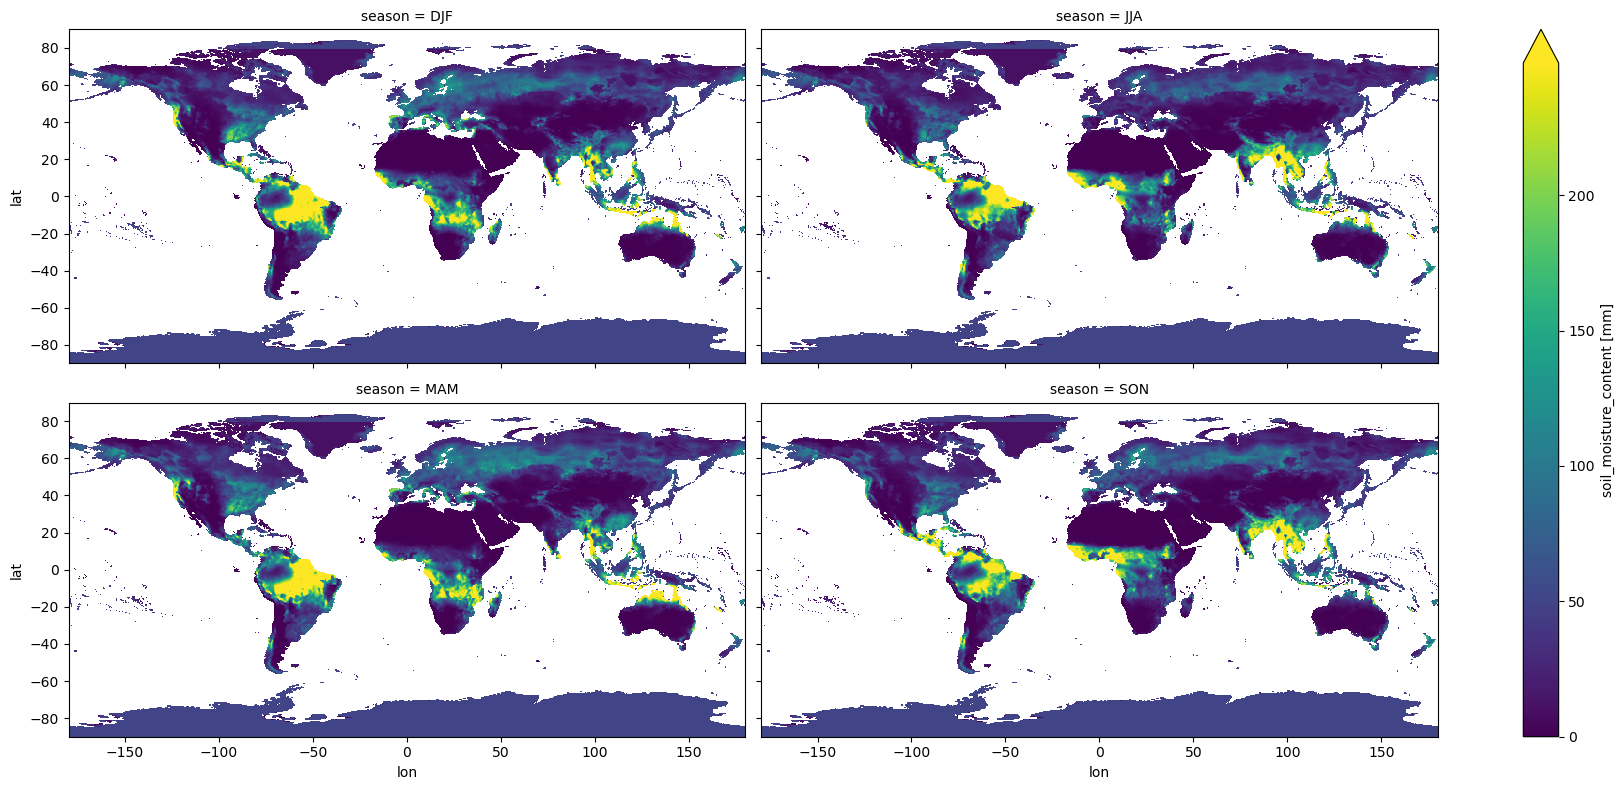

In [10]:
soil_clim.plot(col='season', col_wrap=2, robust=True, figsize=(18, 8))